In [ ]:
import tensorflow as tf
import numpy as np 
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import glob
import tensorflow_datasets as tfds

In [ ]:
directory1 = './input/food41/images/'

In [3]:
AUTO = tf.data.experimental.AUTOTUNE
img_height = 150
img_width = 150
input_shape = (img_height,img_width,3)
rand_int = 42

train = tf.keras.preprocessing.image_dataset_from_directory(directory1,
  
  seed=rand_int,validation_split = 0.25,subset='training',
  image_size=(img_height, img_width),
  batch_size=64,shuffle=True)

test = tf.keras.preprocessing.image_dataset_from_directory(
  directory1,
  seed=rand_int,validation_split = 0.25,subset='validation',
  image_size=(img_height, img_width),
  batch_size=64, shuffle=True)




Found 101000 files belonging to 101 classes.
Using 75750 files for training.
Found 101000 files belonging to 101 classes.
Using 25250 files for validation.


In [4]:
class_names = train.class_names
print(class_names)
print('No of classes: ',len(class_names))
num_classes = len(class_names)


['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [7]:
def image_augmentation(image,label):
    rand_seed = 42
    
    image = tf.cast(image,'float32')
    image = tf.image.random_brightness(image, max_delta = 0.2,seed=rand_seed)
    image = tf.image.random_contrast(image, 0.9, 1.1, seed = rand_seed)
    image = tf.image.random_flip_left_right(image, seed=rand_seed)
    image = tf.image.random_flip_up_down(image, seed = rand_seed)
    image = image/255.0
    return image,label

In [8]:
def resize_and_rescale(image, label):
    image = tf.cast(image,'float32')
    image = image/255.0
    return image,label   

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train.prefetch(AUTOTUNE).map(resize_and_rescale,num_parallel_calls=AUTOTUNE)

test_ds = test.prefetch(AUTOTUNE).map(resize_and_rescale,num_parallel_calls=AUTOTUNE)

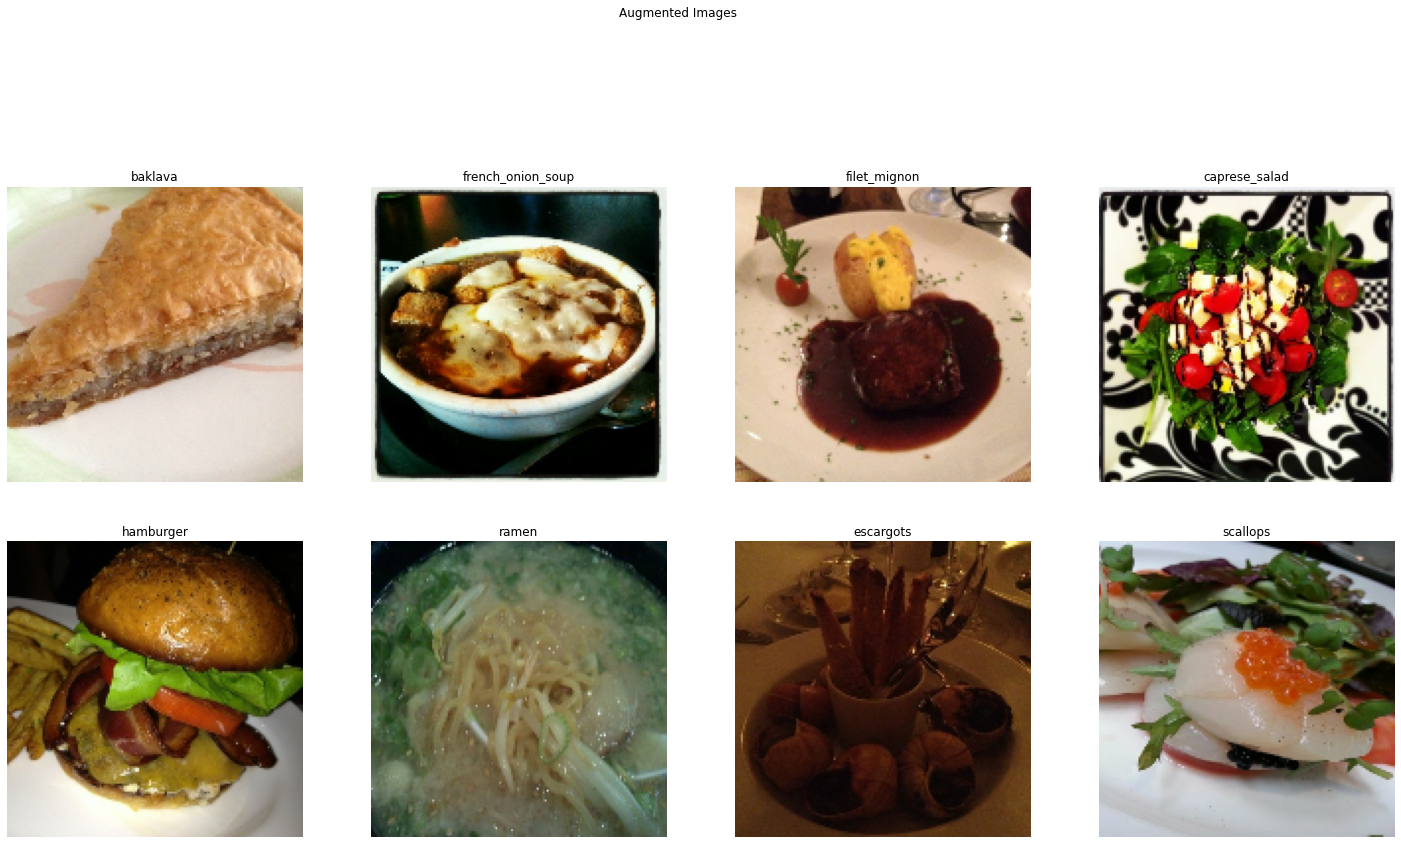

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,25 ))
for images, labels in train_ds.take(1):
    plt.suptitle('Augmented Images')
    for i in range(8):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break

In [11]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 76  # We'll resize input images to this size
patch_size = 12  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [12]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [13]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 76 X 76
Patch size: 12 X 12
Patches per image: 36
Elements per patch: 432


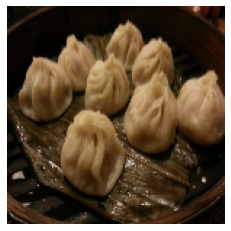

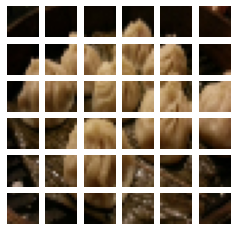

In [14]:
plt.figure(figsize=(4, 4))
for image,label in train_ds.take(1):
  k = np.random.randint(1,10)
  plt.imshow(image[k].numpy())
  plt.axis("off")

  resized_image = tf.image.resize(
      tf.convert_to_tensor([image[k]]), size=(image_size, image_size)
  )
  patches = Patches(patch_size)(resized_image)
  print(f"Image size: {image_size} X {image_size}")
  print(f"Patch size: {patch_size} X {patch_size}")
  print(f"Patches per image: {patches.shape[1]}")
  print(f"Elements per patch: {patches.shape[-1]}")

  n = int(np.sqrt(patches.shape[1]))
  plt.figure(figsize=(4, 4))
  for i, patch in enumerate(patches[0]):
      ax = plt.subplot(n, n, i + 1)
      patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
      plt.imshow(patch_img.numpy())
      plt.axis("off")

In [15]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [16]:
pretrained = tf.keras.applications.ResNet152V2( include_top=False, weights='imagenet')
pretrained.trainable = False
#pretrained.summary()

234553344/234545216 [==============================] - 1s 0us/step


In [17]:
last_layer = pretrained.layers[-1].output
x = layers.Conv2D(256,(1,1),activation='relu')(last_layer)
x = layers.Conv2D(128,(1,1),activation='relu')(x)
x = layers.Conv2D(3,(1,1),activation='relu')(x)
x = tf.keras.layers.UpSampling2D(size = (5,5))(x)
x = tf.keras.layers.UpSampling2D(size = (5,5))(x)


x = layers.experimental.preprocessing.Resizing(image_size, image_size)(x)

conv_block = tf.keras.Model(inputs = pretrained.input, outputs = x)

In [18]:
input_shape = (150,150,3)
inputs = layers.Input(shape=input_shape)

def transformer_block():
    
    conv = conv_block(inputs)
    
    
    # Create patches.
    patches = Patches(patch_size)(conv)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
   
    
    return features

In [19]:
output = transformer_block()
logits = layers.Dense(num_classes,activation='softmax')(output)

In [20]:
model = keras.Model(inputs=inputs, outputs=logits)

In [21]:
#tf.keras.utils.plot_model(model)

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 76, 76, 3)    58889475    input_2[0][0]                    
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 432)    0           model[0][0]                      
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 36, 64)       30016       patches_1[0][0]                  
____________________________________________________________________________________________

In [23]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

In [24]:
model.compile(optimizer=optimizer,loss=keras.losses.SparseCategoricalCrossentropy(),metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"), 
                                                                                                             keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),],)

In [ ]:
history = model.fit( train_ds ,epochs=100, shuffle=True) 